In [3]:
using PyPlot; using Revise; using MDToolbox;
using StatsBase; # for calculating histogram
using Printf; using DelimitedFiles;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

In [7]:
# setup constants
KBT = KB_kcalpermol*300.0

0.59616123

In [8]:
# umbrella window centers
umbrella_center = 0:3:180
K = length(umbrella_center)

61

In [10]:
# define edges for histogram bin
M = 80; # number of bins
edge = range(-1, stop=181, length=M+1)
#edge = linspace(-1, 181, M+1)
bin_center = 0.5 .* (edge[2:end] .+ edge[1:(end-1)])

0.1375:2.275:179.8625

In [11]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/umbrella_alat/3_prod/run_%d.dat" umbrella_center[k]
  x = readdlm(filename);
  push!(data_k, x[:, 2])
end

In [12]:
# calculate histogram (h_km)
# h_km: histogram (data counts) of k-th umbrella data counts in m-th data bin
h_km = zeros(Int64, K, M)
for k = 1:K
  h = fit(Histogram, data_k[k], edge)
  h_m = h.weights
  h_km[k, :] = h_m
end

In [13]:
# bias-energy
# bias_km: bias-factor of k-th umbrella-window evaluated at m-th bin-center
function minimum_image(center, x)
  dx = x .- center
  dx = dx .- round.(dx./360.0).*360.0;
  dx
end

bias_km = zeros(Float64, K, M)
spring_constant = 200.0 * (pi/180.0)^2; # conversion of the unit from kcal/mol/rad^2 to kcal/mol/deg^2
for k = 1:K
  for m = 1:M
    bias_km[k, m] = (spring_constant./KBT) * (minimum_image(Float64(umbrella_center[k]), bin_center[m])).^2
  end
end

In [14]:
# solve WHAM equations, and
# calculate probabilities in the dihedral angle space, and evaluate the potential of mean force (PMF)
f_k, pmf_m = wham(h_km, bias_km)
pmf_m = KBT .* pmf_m;
pmf_m = pmf_m .- pmf_m[1]

100th iteration  delta = 1.787639e-02  tolerance = 1.000000e-08
free energies = 0.000000 -0.367181 -0.426526 -0.406166 -0.305827 -0.185733 0.014576 0.276855 0.493765 0.667860 0.889302 1.119564 1.417670 1.833230 2.189434 2.535364 2.943824 3.535422 4.126133 4.741962 5.447195 6.199439 6.925808 7.777487 8.800008 9.824828 10.671452 11.091163 11.138219 10.813999 10.133250 9.358142 8.518488 7.670383 6.881873 6.163108 5.618457 5.035230 4.449888 4.053553 3.681521 3.241482 2.695836 2.185885 1.746191 1.337470 0.869971 0.392527 0.041430 -0.275562 -0.510140 -0.608318 -0.757343 -0.923356 -1.009765 -1.118059 -1.193799 -1.297122 -1.400955 -1.399006 -1.001699 

200th iteration  delta = 5.854655e-03  tolerance = 1.000000e-08
free energies = 0.000000 -0.349055 -0.367129 -0.284243 -0.093204 0.140441 0.474283 0.899300 1.308932 1.689139 2.127874 2.600789 3.133837 3.811096 4.451294 5.078424 5.745409 6.597855 7.469224 8.340398 9.284672 10.270312 11.210769 12.227551 13.401937 14.559189 15.516190 16.010271 16.0

1×80 Array{Float64,2}:
 0.0  -0.0169813  0.0474963  0.00841233  0.119576  …  -6.87581  -7.06381  -7.13121  -7.21595  -7.13705

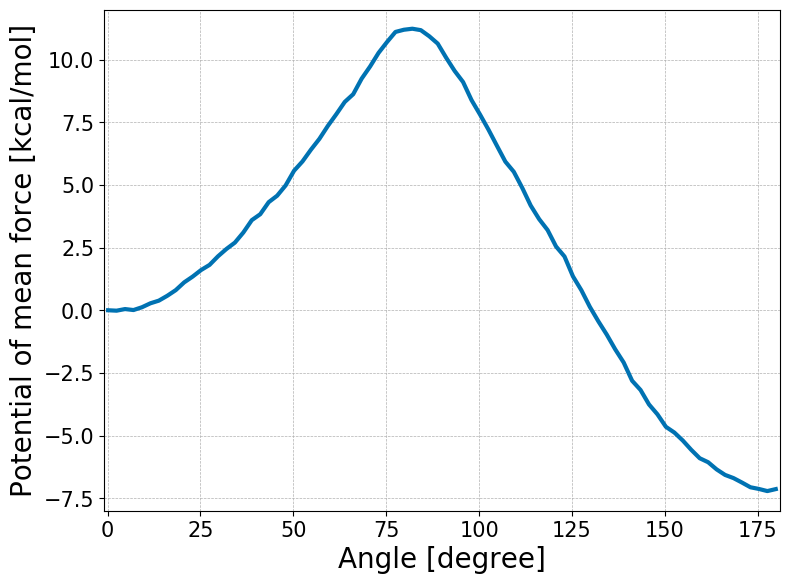

In [15]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(bin_center, pmf_m[:], linewidth=3)
xlabel("Angle [degree]",fontsize=20)
ylabel("Potential of mean force [kcal/mol]",fontsize=20)

# detailed options (not necessary, just for reference)
ax.set(xlim=[-1, 181], ylim=[-8, 12])
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

savefig("wham.png", dpi=350)